In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import sys
import timeit
from pynx.ptycho.bragg import *
from pynx.wavefront import Wavefront, ImshowRGBA, PropagateNearField
from pynx.utils.math import smaller_primes
from silx.io.specfile import SpecFile
import fabio
from scipy.ndimage.measurements import center_of_mass
default_processing_unit.use_gpu()

gpyfft version: 0.7.0
Computing FFT speed for available CUDA GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                         GeForce GTX TITAN X: 12287Mb , 305.30 Gflop/s
Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                           GeForce GTX TITAN X [NVIDIA CUDA]: 12287Mb [max alloc.: 3072Mb], 250.27 Gflop/s
Using CUDA GPU: GeForce GTX TITAN X


True

In [2]:
# Bragg ptycho parameters
specfile= "data/spec/e17089.spec"
scan0, scan1 = 139, 223  # scan range
image_prefix= "/data/visitor/hc3211/id01/mpx/e17089/20171026night//data_mpx4_%05d.edf.gz"

In [3]:
# 
# Read spec scans
vs = {}
first = True
for i in range(scan0,scan1+1):
    s = SpecFile(specfile)['%d.1' % (i)]
    h = s.scan_header_dict
    if first:
        nrj = float(h['UMONO'].split('mononrj=')[1].split('ke')[0])
        wavelength = 12.384 / nrj * 1e-10
        print("Reading nrj from spec data: nrj=%6.3fkeV, wavelength=%6.3fA" % (nrj, wavelength*1e10))
        detector_distance = float(h['UDETCALIB'].split('stance_CC=')[1].split(',')[0])
        #detector_distance = 1.401096
        print("Detector distance: %6.3fm"% detector_distance)
        first=False
    vs[i]={'eta':np.deg2rad(s.motor_position_by_name('eta')),
           'phi':np.deg2rad(s.motor_position_by_name('phi')), 
           'del':np.deg2rad(s.motor_position_by_name('del')),
           'del':np.deg2rad(s.motor_position_by_name('del')),
           'nu':np.deg2rad(s.motor_position_by_name('nu')),
           'mpx4inr':s.data_column_by_name('mpx4inr').astype(np.int),
           'pix': s.data_column_by_name('pix') ,'piy': s.data_column_by_name('piy'),
           'mpx4int': s.data_column_by_name('mpx4int'),
           'roi2': s.data_column_by_name('roi2'),
           'roi4': s.data_column_by_name('roi4'),
           'filter': float(h['UFILT1'])
          }

Reading nrj from spec data: nrj= 8.000keV, wavelength= 1.548A
Detector distance:  0.500m


Angular range= 1.620°, step=0.0195°, 85 spirals
42


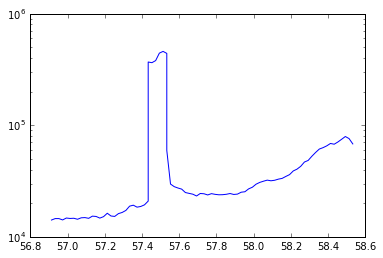

In [4]:
# Angular scan parameters
filter_f = 3.9
npsi = len(vs)
veta = np.array([ vs[i]['eta'] for i in range(scan0,scan1)])
iobssum = np.array([ vs[i]['mpx4int'].sum() * filter_f**vs[i]['filter'] for i in range(scan0,scan1)])
roi4sum = np.array([ vs[i]['roi4'].sum() * filter_f**vs[i]['filter'] for i in range(scan0,scan1)])
roi2sum = np.array([ vs[i]['roi2'].sum() * filter_f**vs[i]['filter'] for i in range(scan0,scan1)])
etastep = (veta[-1] - veta[0])/(len(veta)-1)
print("Angular range= %5.3f°, step=%6.4f°, %d spirals"%(np.rad2deg(veta[-1] - veta[0]), np.rad2deg(etastep), npsi))
# Intensity vs angle
%matplotlib inline
plt.semilogy(np.rad2deg(veta), roi2sum)
#ipsi0 = int(round(center_of_mass(np.array(roi2sum))[0]))
ipsi0 = len(iobssum)//2
print(ipsi0)

In [5]:
# Load all images for the central spiralscan
iscan0 = scan0 + ipsi0
print('iscan0=',iscan0)
iobsc = None
ii = 0
t0= timeit.default_timer()
for i in vs[iscan0]['mpx4inr']:
    if (i - vs[iscan0]['mpx4inr'][0]) % 20 == 0:
        sys.stdout.write('%d ' % (i - vs[iscan0]['mpx4inr'][0]))
        sys.stdout.flush()
    frame = np.fliplr(fabio.open(image_prefix % i).data)
    if iobsc is None:
        iobsc = np.empty((len(vs[iscan0]['mpx4inr']), frame.shape[0], frame.shape[1]), dtype=frame.dtype)
    iobsc[ii] = frame
    ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobsc.size / 1e6 / dt))

iscan0= 181
0 20 

Time to read all frames:  0.6s [14.89 Mpixel/s]


Center of mass: y0=226.8, x0=276.1


/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


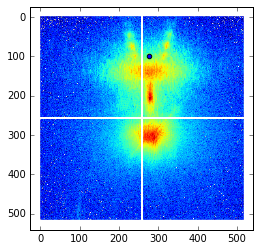

In [6]:
# Find center of diffraction
plt.imshow(np.log10(iobsc.sum(axis=0)))
y0, x0 = center_of_mass(iobsc.sum(axis=0))
print("Center of mass: y0=%5.1f, x0=%5.1f"%(y0,x0))
ny0, nx0 = iobsc.shape[-2:]
ix0 = int(round(x0))
iy0 = int(round(y0))

if True:
    # Manually correct position
    #ix0 -= 35
    iy0 = 100
plt.scatter([ix0],[iy0])  # To check visually

In [7]:
# Load the first 3D dataset, for the first point of the spiralscans
iobs0 = np.empty((npsi,516,516),dtype=np.float32)
ii = 0
t0= timeit.default_timer()
print("%d frames to read:"%(npsi))
ipos = 0
for ipsi in range(scan0,scan1+1):
    i = vs[ipsi]['mpx4inr'][ipos]
    corr = filter_f ** vs[ipsi]['filter']
    if ii % 20 == 0:
        sys.stdout.write('%d ' % (ii))
        sys.stdout.flush()
    frame = np.fliplr(fabio.open(image_prefix % i).data) * corr
    iobs0[ipsi-scan0] = frame
    ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobs0.size / 1e6 / dt))

85 frames to read:
0 20 40 60 80 

Time to read all frames:  1.4s [16.51 Mpixel/s]


/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


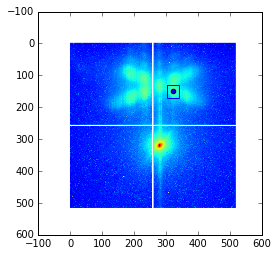

In [8]:
# choose area to integrate
%matplotlib inline
plt.imshow(np.log10(iobs0.sum(axis=0)))
ix0, iy0= 322, 150
plt.scatter([ix0],[iy0])  # To check visually
dxy = 20
plt.plot([ix0-dxy,ix0+dxy,ix0+dxy,ix0-dxy,ix0-dxy], [iy0-dxy,iy0-dxy,iy0+dxy,iy0+dxy,iy0-dxy])
#plt.xlim(ix0-2*dxy,ix0+2*dxy)
#plt.ylim(iy0+2*dxy,iy0-2*dxy)

35


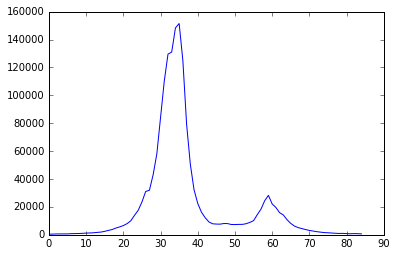

In [9]:
iobs0sat0 = iobs0[:,iy0-dxy:iy0+dxy,ix0-dxy:ix0+dxy].sum(axis=(-2,-1))
plt.plot(iobs0sat0)
ipsi0 = np.argmax(iobs0sat0)
print(ipsi0)

In [10]:
# Size of crop array
nx, ny = dxy*2, dxy*2
npsi = 2*20
# crop to max fft size
#npsi, ny, nx = smaller_primes((npsi, ny, nx), maxprime=default_processing_unit.max_prime_fft, required_dividers=(2,))
veta = veta[ipsi0-npsi//2:ipsi0+npsi//2]

(33,)


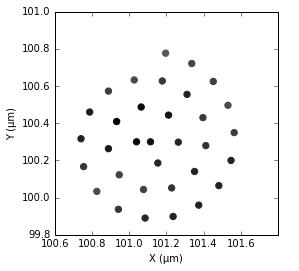

In [11]:
# Select area - if there are too positions in the spiralscan
#plt.plot(vs[ic]['pix'],iobsc.sum(axis=(1,2)))
v = iobsc.sum(axis=(1,2))
xp = vs[iscan0]['pix']
yp = vs[iscan0]['piy']
zp = 0 * xp
%matplotlib inline
ax=plt.scatter(xp,yp,40,v/v.max(), vmin=0,vmax=1, cmap=plt.cm.Greys, edgecolors='face')
plt.gca().set_aspect(1)
plt.xlabel('X (µm)')
plt.ylabel('Y (µm)')
print(zp.shape)

In [12]:
vpos = np.arange(len(xp))  #np.nonzero((xp>94.5)*(xp<95.3)*(yp>111)*(yp<111.7))[0]
npos = len(vpos)
print("Number of scan positions selected: %d"%(npos))

Number of scan positions selected: 33


In [13]:
# Now load all the data
iobs = np.empty((npos,npsi,ny,nx),dtype=np.float32)
ii = 0
t0= timeit.default_timer()
print("%d frames to read:"%(npos*npsi))
for j in range(len(vpos)):
    ipos = vpos[j]
    for ipsi in range(scan0+ipsi0-npsi//2, scan0+ipsi0+npsi//2):
        i = vs[ipsi]['mpx4inr'][ipos]
        corr = filter_f ** vs[ipsi]['filter']
        if ii % 20 == 0:
            sys.stdout.write('%d ' % (ii))
            sys.stdout.flush()
        frame = np.fliplr(fabio.open(image_prefix % i).data) * corr
        iobs[j, ipsi-(scan0+ipsi0-npsi//2)] = frame[iy0-ny//2:iy0+ny//2,ix0-nx//2:ix0+nx//2]
        ii += 1
print("\n")
dt = timeit.default_timer() - t0
print('Time to read all frames: %4.1fs [%5.2f Mpixel/s]' % (dt, iobs.size / 1e6 / dt))

1320 frames to read:
0 20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 

Time to read all frames: 25.2s [ 0.08 Mpixel/s]


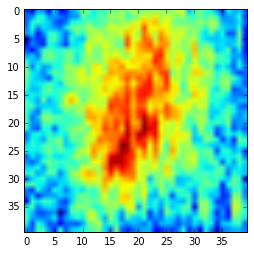

In [25]:
%matplotlib inline
#plt.imshow(np.log10(iobs[6,:].sum(axis=(0))))
#plt.imshow(np.log10(iobs.sum(axis=(0,-2))))
plt.imshow(np.log10(iobs[15,20]))

In [15]:
# Experiment parameters
pixel_size_detector = 55e-6
psi_step = etastep
print("Cropped angular range: %6.3f, step=%6.4f"%(np.rad2deg(psi_step)*npsi, np.rad2deg(psi_step)))

Cropped angular range:  0.781, step=0.0195


In [16]:
## Ptycho data

# Use only one stack - if memory allows it !
default_processing_unit.cl_stack_size = npos

# detector parameters
nu = vs[scan0]['nu']
delta = vs[scan0]['del']
eta0 = veta.mean()
detector = {'geometry': 'psic', 'delta': delta, 'nu': nu, 'pixel_size': pixel_size_detector,
            'distance': detector_distance, 'rotation_axis': 'eta', 'rotation_step': psi_step}
zs, ys, xs = zp[vpos] * 1e-6, yp[vpos] * 1e-6, xp[vpos] * 1e-6

ys *= np.sin(veta.mean())  # (we don't care about movement along z)

print('del= %5.2f nu =%5.2f eta0=%5.2f eta_step=%6.4f'%(np.rad2deg(detector['delta']),np.rad2deg(detector['nu']), np.rad2deg(eta0),np.rad2deg(detector['rotation_step'])))
# Create empty data
data = BraggPtychoData(iobs=iobs, positions=(zs, -ys, -xs), mask=None, wavelength=wavelength, detector=detector)

del= 76.30 nu = 0.00 eta0=57.58 eta_step=0.0195


Computing FFT speed for available CUDA GPU:
                                         GeForce GTX TITAN X: 12287Mb
Using CUDA GPU: GeForce GTX TITAN X


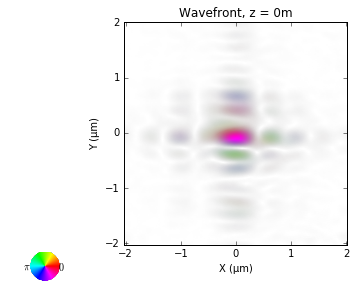

In [17]:
# Import existing probe from 2D ptycho - only the first mode will be used
d = np.load("ResultsScan0010/latest.npz") # Siemens star
#d = np.load("ResultsScan0096/latest.npz")  # use the bragg ptycho scan
dpr = np.fft.fftshift(d['probe'],axes=(-2,-1))  # just flip the x,y axes - not the modes
#
pr = Wavefront(d=dpr, z=0, pixel_size=d['pixelsize'], wavelength=wavelength)
%matplotlib inline
pr = ImshowRGBA() * PropagateNearField(0e-6) * pr

In [18]:
# Create main Bragg Ptycho object
p = BraggPtycho(probe=pr, data=data, support=None)
pxyz = p.voxel_size_object()
print("Object voxel size: %6.2fnm x %6.2fnm x %6.2fnm" % (pxyz[0] * 1e9, pxyz[1] * 1e9, pxyz[2] * 1e9))

Calculating probe on object grid
Initialised object with 104x56x74 voxels
Object voxel size:  11.69nm x  44.74nm x  35.18nm


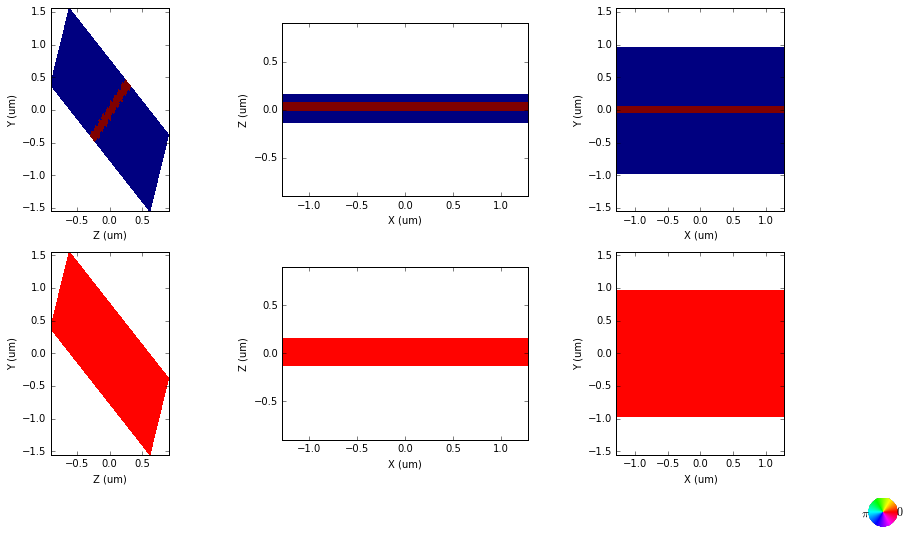

In [19]:
%matplotlib inline
# Create starting object
x, y, z = p.get_xyz(domain='object', rotation=('x', eta0))
obj0 = (abs(y) < 62e-9)
#obj0 = obj0 * np.random.uniform(0,1,obj0.shape)
p.set_obj(obj0)

p = ShowObj() * p

# Set a support larger than the object
sup = (abs(y) < 80e-9)
p.set_support(sup)


Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                           GeForce GTX TITAN X [NVIDIA CUDA]: 12287Mb [max alloc.: 3072Mb], 250.74 Gflop/s
Using OpenCL GPU: GeForce GTX TITAN X
Using OpenCL GPU: GeForce GTX TITAN X
Moving observed data to OpenCL GPU
Moving object, probe, mask, support to OpenCL GPU
DM #  0 LLK=    88.11(p)    43.31(g)    76.21(e), nb photons=7.871429e+06, dt/cycle=0.051s


<IPython.core.display.Javascript object>


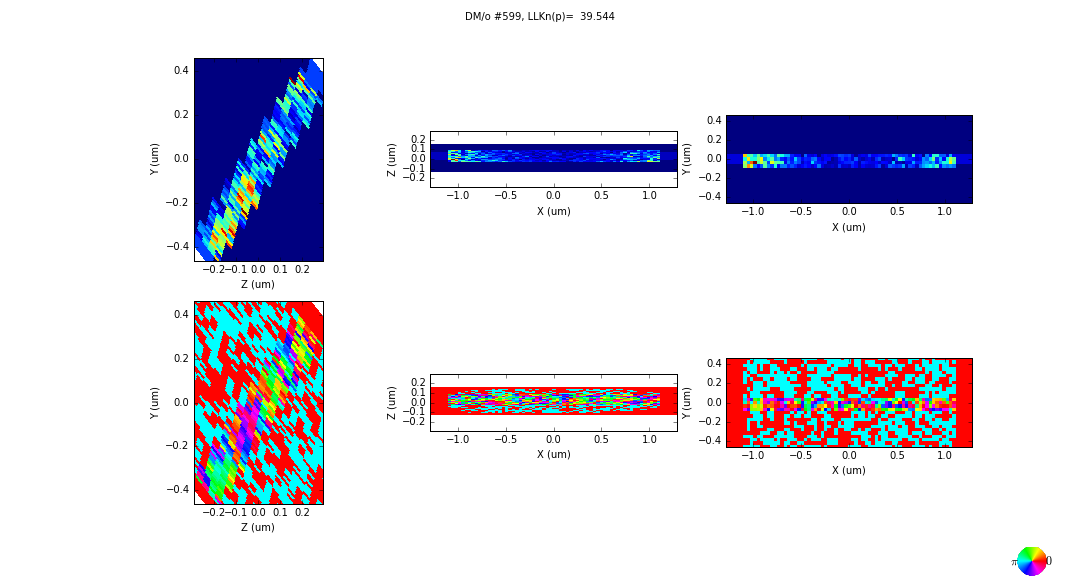

/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


DM # 10 LLK=    47.07(p)    19.26(g)    47.88(e), nb photons=1.406018e+07, dt/cycle=0.013s
DM # 20 LLK=    41.25(p)    22.12(g)    44.15(e), nb photons=1.536255e+07, dt/cycle=0.012s
DM # 30 LLK=    40.41(p)    21.93(g)    43.83(e), nb photons=1.527264e+07, dt/cycle=0.013s
DM # 40 LLK=    39.65(p)    22.78(g)    43.38(e), nb photons=1.539448e+07, dt/cycle=0.012s
DM # 50 LLK=    39.63(p)    22.75(g)    43.33(e), nb photons=1.545990e+07, dt/cycle=0.012s
DM # 60 LLK=    39.54(p)    22.60(g)    43.27(e), nb photons=1.548831e+07, dt/cycle=0.012s
DM # 70 LLK=    39.53(p)    22.59(g)    43.36(e), nb photons=1.528160e+07, dt/cycle=0.012s
DM # 80 LLK=    39.61(p)    23.02(g)    43.36(e), nb photons=1.538187e+07, dt/cycle=0.012s
DM # 90 LLK=    39.17(p)    22.69(g)    42.91(e), nb photons=1.566142e+07, dt/cycle=0.012s
DM #100 LLK=    39.58(p)    22.48(g)    43.36(e), nb photons=1.536561e+07, dt/cycle=0.012s
DM #110 LLK=    39.77(p)    22.42(g)    43.51(e), nb photons=1.522697e+07, dt/cycle=0.012s

<IPython.core.display.Javascript object>


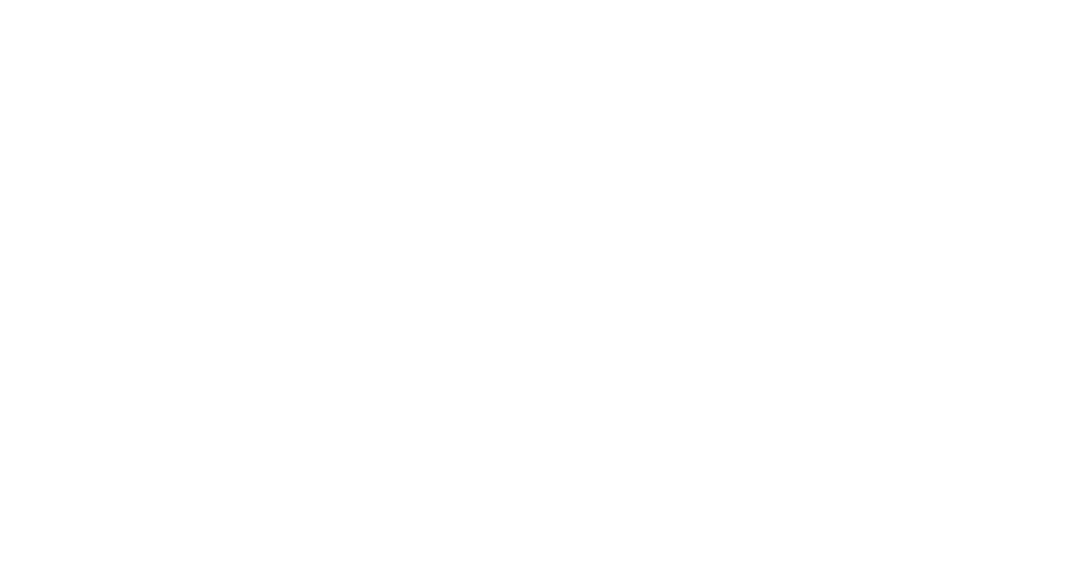

In [20]:
%matplotlib notebook
p = DM(calc_llk=10, show_obj_probe=20) ** 600 * p

AP #  0 LLK=    39.54(p)    22.18(g)    43.24(e), nb photons=1.544221e+07, dt/cycle=0.018s


<IPython.core.display.Javascript object>


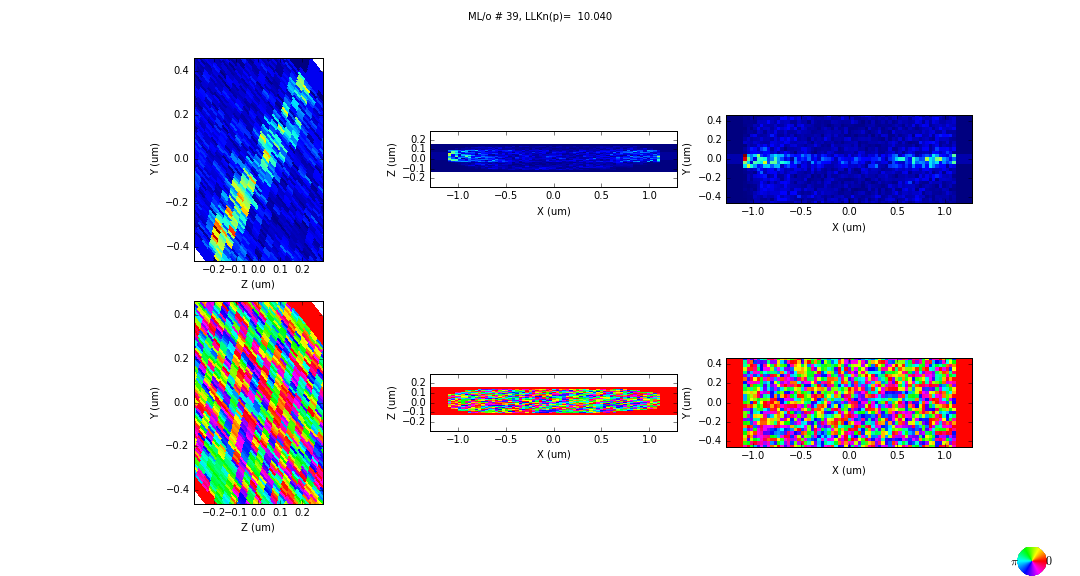

/mntdirect/_data_id01_inhouse/favre/dev/debug/lib/python3.4/site-packages/matplotlib/backend_bases.py:2437: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


AP # 10 LLK=    15.73(p)    80.88(g)    25.51(e), nb photons=4.242103e+07, dt/cycle=0.012s
AP # 20 LLK=    14.86(p)    80.58(g)    24.61(e), nb photons=4.292766e+07, dt/cycle=0.012s
AP # 30 LLK=    14.47(p)    80.24(g)    24.19(e), nb photons=4.316206e+07, dt/cycle=0.009s
AP # 39 LLK=    14.23(p)    80.09(g)    23.94(e), nb photons=4.330117e+07, dt/cycle=0.009s
ML #  0 LLK=    14.20(p)    80.09(g)    23.92(e), nb photons=4.331442e+07, dt/cycle=0.039s
ML # 10 LLK=    17.78(p)  2659.01(g)    37.45(e), nb photons=6.101022e+07, dt/cycle=0.016s
ML # 20 LLK=    11.98(p)   182.99(g)    25.47(e), nb photons=5.578746e+07, dt/cycle=0.017s
ML # 30 LLK=    10.58(p)   167.88(g)    23.19(e), nb photons=5.589223e+07, dt/cycle=0.017s
ML # 39 LLK=    10.04(p)   162.00(g)    22.25(e), nb photons=5.605989e+07, dt/cycle=0.018s


<IPython.core.display.Javascript object>


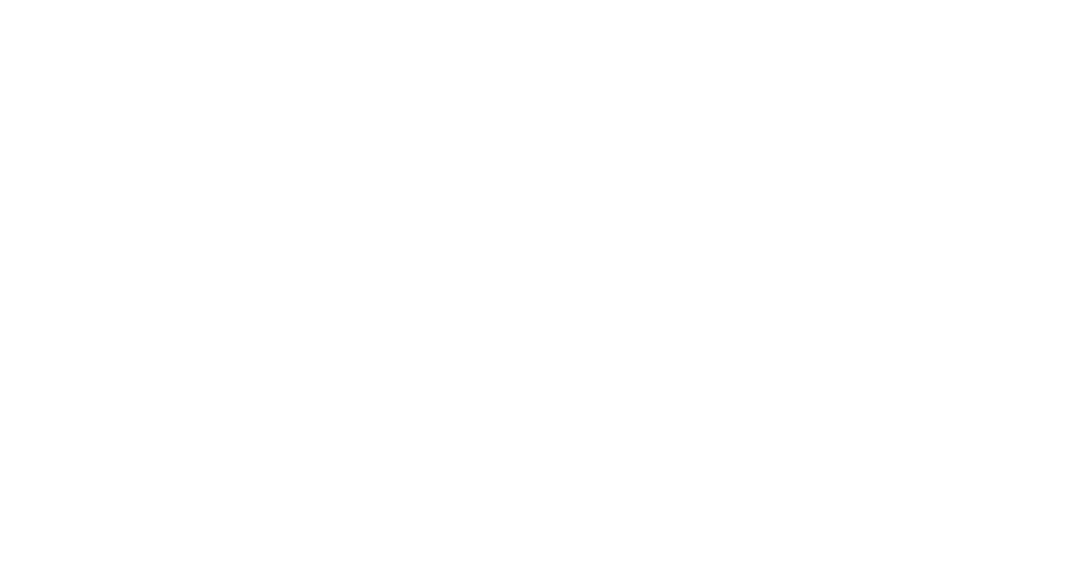

In [21]:
p = AP(calc_llk=10, show_obj_probe=10) ** 40 * p
p = ML(calc_llk=10, show_obj_probe=10) ** 40 * p

In [22]:
p=FreePU()*p
#p=ShowObj()*AP()**40*p

In [26]:
ipsi0,ix0,iy0

(35, 322, 150)